In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('max_columns',2000)
pd.set_option('max_rows',2000)
Train=pd.read_csv('train_cleaned.csv')
Test=pd.read_csv('test_cleaned.csv')
Id=Test['Id']
Test=Test.drop(['Id'],axis=1)
X=Train.drop(['SalePrice'],axis=1)
y=Train['SalePrice']
X=X.apply(lambda s: np.log(s+1))
Test=Test.apply(lambda s: np.log(s+1))

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeRegressor

tree_model=DecisionTreeRegressor()
selector = SelectFromModel(tree_model , threshold =1e-12,prefit = False).fit(X, y)
# print(selector.threshold_)
# print(selector.estimator_)
# print(DecisionTreeRegressor().fit(X, y).feature_importances_)
X_red=selector.transform(X)
Test_red=selector.transform(Test)


In [3]:
X_red.shape

(1460, 145)

In [16]:
from vecstack import StackingTransformer
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
estimators_1st = [('svr', SVR(kernel='poly', degree=3, gamma='auto',max_iter=1000)),
               ('lin',LinearRegression()),
                  #('rid',Ridge(alpha=1.0)),
                  ('krr',KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)),
              ('EN', ElasticNet()),
              #('dtr', DecisionTreeRegressor(random_state=0,max_depth=8)),
             ('knr',KNeighborsRegressor(n_neighbors=3,n_jobs=2)),
             #('etr',ExtraTreesRegressor(n_estimators=600, max_depth=5)),
            ('xgbr',XGBRegressor(learning_rate=0.05,n_estimators=600,max_depth=3)),
            #('rfr',RandomForestRegressor(n_estimators=600, max_depth=9)),
            ('gbr',GradientBoostingRegressor(learning_rate=0.06,n_estimators=600,max_depth=3))
]

# Initialize StackingTransformer
stack_1st = StackingTransformer(estimators_1st,n_folds=5 , regression=True, verbose=2)
stack_1st = stack_1st.fit(X_red, y)

# Get your stacked features
metaX = stack_1st.transform(X_red)
metaTest = stack_1st.transform(Test_red)

# Use 2nd level estimator with stacked features

task:         [regression]
metric:       [mean_absolute_error]
variant:      [A]
n_estimators: [7]

estimator  0: [svr: SVR]
    fold  0:  [54505.33074612]
    fold  1:  [58904.99324510]
    fold  2:  [57264.84703911]
    fold  3:  [49063.67677693]
    fold  4:  [54715.28214419]
    ----
    MEAN:     [54890.82599029] + [3343.19023897]

estimator  1: [lin: LinearRegression]
    fold  0:  [6468947388.29794502]
    fold  1:  [539362495870973.56250000]
    fold  2:  [6984241521.59032536]
    fold  3:  [21534.45954623]
    fold  4:  [24533.15132705]
    ----
    MEAN:     [107875189821190.20312500] + [215743653045925.65625000]

estimator  2: [krr: KernelRidge]
    fold  0:  [17273.39976528]
    fold  1:  [20765.57114317]
    fold  2:  [20775.05803095]
    fold  3:  [18355.93743196]
    fold  4:  [21286.33251479]
    ----
    MEAN:     [19691.25977723] + [1581.27501764]

estimator  3: [EN: ElasticNet]
    fold  0:  [26726.86951887]
    fold  1:  [30760.45922693]
    fold  2:  [29028.1391796

In [18]:
#[0.0, 0.0, 0.15000000000000002, 0.0, 0.1, 0.0, 0.25, 0.0, 0.5]
from sklearn.linear_model import Lasso

# model=Lasso(alpha =1)
# model.fit(metaX,y)
# y_pred_stack=model.predict(metaX)
# print((np.mean((np.log(y_pred_stack)-np.log(y))**2))**0.5)
# test_pred_stack=model.predict(metaTest)
y_pred_stack=[row[0]*0+row[1]*0+row[2]*0.1+row[3]*0.1+row[4]*0+row[5]*0.3+row[5]*0.5  for row in metaX]
print((np.mean((np.log(y_pred_stack)-np.log(y))**2))**0.5)
test_pred_stack=[row[0]*0+row[1]*0+row[2]*0.1+row[3]*0.1+row[4]*0+row[5]*0.3+row[5]*0.5  for row in metaTest]

0.13024596420009676


In [19]:
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

metaX=pd.DataFrame(metaX)
metaTest=pd.DataFrame(metaTest)
scaler=StandardScaler()
metaX_norm=scaler.fit_transform(metaX)
metaTest_norm=scaler.fit_transform(metaTest)

model=XGBRegressor(learning_rate=0.05,n_estimators=700,max_depth=2)
model.fit(metaX_norm,y)
y_pred_stack_xgb=model.predict(metaX_norm)
print((np.mean((np.log(y_pred_stack_xgb)-np.log(y))**2))**0.5)
test_pred_stack_xgb=model.predict(metaTest_norm)

C:\Users\USER\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\USER\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:55:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.09916121108534136


In [20]:
from xgboost import XGBRegressor

#{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 600}
model=XGBRegressor(learning_rate=0.05,n_estimators=700,max_depth=3)

model.fit(X_red,y)
y_pred_xgb=model.predict(X_red)
print((np.mean((np.log(y_pred_xgb)-np.log(y))**2))**0.5)
test_pred_xgb=model.predict(Test_red)

[11:55:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.06854819653571832


In [28]:
# from sklearn.ensemble import GradientBoostingRegressor
# model=GradientBoostingRegressor(learning_rate=0.05,n_estimators=600,max_depth=3)

# model.fit(X_red,y)
# y_pred_gb=model.predict(X_red)
# print((np.mean((np.log(y_pred_gb)-np.log(y))**2))**0.5)
# test_pred_gb=model.predict(Test_red)

0.06570391903139731


In [23]:
#weighted average of the output of the stacking
# weighted=[0]*3
# bestscore=10
# for a in np.arange(0,1.001,0.01):
#     for b in np.arange(0,1.001-a,0.01):
#         prediction=[y_pred_stack[i]*a+y_pred_xgb[i]*b+y_pred_gb[i]*(1-a-b) for i in range(len(y_pred_gb))]
#         score=(np.mean((np.log(prediction)-np.log(y))**2))**0.5
#         if bestscore>score:
#             bestscore=score
#             weighted=[a,b,1-a-b]
                                
# print(weighted,bestscore)
prediction=[y_pred_stack[i]*0.2+y_pred_stack_xgb[i]*0.7+y_pred_xgb[i]*0.1 for i in range(len(y_pred_xgb))]
print((np.mean((np.log(prediction)-np.log(y))**2))**0.5)
# prediction=[test_pred_stack[i]*a+test_pred_xgb[i]*b+test_pred_gb[i]*(1-a-b) for i in range(len(test_pred_gb))]
prediction=[test_pred_stack[i]*0.2+test_pred_stack_xgb[i]*0.7+test_pred_xgb[i]*0.1 for i in range(len(test_pred_xgb))]
ans=pd.DataFrame({'Id':Id,'SalePrice':prediction})
ans.to_csv('SUBMISSION.csv',index = False)

0.09962461378059281


In [16]:
# #weighted average of the output of the stacking
# weighted=[0]*9
# bestscore=10
# for a in np.arange(0,1,0.05):
#     for b in np.arange(0,1-a,0.05):
#         for c in np.arange(0,1-a-b,0.05):
#             for d in np.arange(0,1-a-b-c,0.05):
#                 for e in np.arange(0,1-a-b-c-d,0.05):
#                     for f in np.arange(0,1-a-b-c-d-e,0.05):
#                         for g in np.arange(0,1-a-b-c-d-e-f,0.05):
#                             for h in np.arange(0,1-a-b-c-d-e-f-g,0.05):
#                                 prediction=[x[0]*a+x[1]*b+x[2]*c+
#                                             x[3]*d+x[4]*e+x[5]*f+
#                                             x[6]*g+x[7]*h+x[8]*(1-a-b-c-d-e-f-g-h) for x in metaX]
#                                 score=(np.mean((np.log(prediction)-np.log(y))**2))**0.5
#                                 if bestscore>score:
#                                     bestscore=score
#                                     weighted=[a,b,c,d,e,f,g,h,1-a-b-c-d-e-f-g-h]
# print(weighted,bestscore)

# prediction=[x[0]*weighted[0]+x[1]*weighted[1]+x[2]*weighted[2]+
#             x[3]*weighted[3]+x[4]*weighted[4]+x[5]*weighted[5]+
#             x[6]*weighted[6]+x[7]*weighted[7]+x[8]*weighted[8] for x in metaTest]
# ans=pd.DataFrame({'Id':Id,'SalePrice':prediction})
# ans.to_csv('SUBMISSION.csv',index = False)
#[0.0, 0.0, 0.15000000000000002, 0.0, 0.1, 0.0, 0.25, 0.0, 0.5]

In [33]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
reg =XGBRegressor()
p = {
    'learning_rate':np.arange(0.02,0.1,0.01),'n_estimators':np.arange(100,800,100),'max_depth':np.arange(2,7,1)
}
grid = GridSearchCV(reg, p,scoring='neg_mean_squared_log_error', cv=10, n_jobs=4)
grid.fit(X_red, y)
grid.best_params_

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\USER\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-33-d6e3aeb6737e>", line 8, in <module>
    grid.fit(X_red, y)
  File "C:\Users\USER\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 722, in fit
    self._run_search(evaluate_candidates)
  File "C:\Users\USER\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 1191, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "C:\Users\USER\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 711, in evaluate_candidates
    cv.split(X, y, groups)))
  File "C:\Users\USER\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py", line 930, in __call__
    self.retrieve()
  File "C:\Users\USER\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py", line 833, in retrieve
    self._ou

KeyboardInterrupt: 

In [24]:
# supermetaX=pd.concat([pd.DataFrame(X_red),pd.DataFrame(metaX,columns=['m_'+str(i) for i in range(len(estimators_1st))])],axis=1)
# supermetaTest=pd.concat([pd.DataFrame(Test_red),pd.DataFrame(metaTest,columns=['m_'+str(i) for i in range(len(estimators_1st))])],axis=1)

In [19]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
#{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 600}
model=XGBRegressor(learning_rate=0.009,n_estimators=500,max_depth=2)
# def ro_me_sq_log_err(y, pre):
#      return np.mean((np.log(pre)-np.log(y))**2)
# scorer = make_scorer(ro_me_sq_log_err, greater_is_better=False)
# s = cross_val_score(model,X_red, y, scoring=scorer,cv=10)
# print("十次:", s)
# print("平均:", np.average(s))
model.fit(metaX2,y)
prediction=model.predict(metaX2)
print((np.mean((np.log(prediction)-np.log(y))**2))**0.5)

C:\Users\USER\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\USER\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:47:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.12493648341521463


In [20]:
prediction=model.predict(metaTest2)
ans=pd.DataFrame({'Id':Id,'SalePrice':prediction})
ans.to_csv('SUBMISSION.csv',index = False)

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca.fit(X_red)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
X_red=pca.transform(X_red)
Test_red=pca.transform(Test_red)

[8.00857685e-01 1.98102445e-01 1.83881801e-04 8.27978507e-05
 6.57937990e-05 5.80054133e-05 4.42271893e-05 3.74260798e-05
 3.63243148e-05 3.18501106e-05 3.00349501e-05 2.96057974e-05
 2.87089755e-05 2.81275219e-05 2.65867353e-05 2.61972326e-05
 2.52945943e-05 2.31763780e-05 2.19216889e-05 2.07285882e-05]
[6441.56494798 3203.7501075    97.60747785   65.49727745   58.38566057
   54.82112946   47.86944434   44.03529253   43.38228587   40.62273774
   39.4481984    39.16535772   38.56759553   38.17503574   37.11472285
   36.8418495    36.20158414   34.65265374   33.70161564   32.7716704 ]


In [19]:
cor=pd.DataFrame(X_red).corr()
threshold=0.90
corList=[]
for i in range(cor.shape[0]):
    corList.append([])
    for j in range(cor.shape[0]):
        if i>j:
            if abs(cor.iloc[i,j])>threshold:
                corList[-1].append(j)

todel=set()            
for i in range(len(corList)):
    for j in corList[i]:
        todel.add(j)
todel=list(delList)
pd.DataFrame(X_red).drop(todel,axis=1).shape

(1460, 82)

In [5]:
# from sklearn.ensemble import RandomForestRegressor
# estimators_2nd = [#('svr', SVR(kernel='poly', degree=3, gamma='auto',max_iter=500)),
#               ('rfr1',RandomForestRegressor(n_estimators=200,random_state=0,max_depth=5)),
#              ('rfr2',RandomForestRegressor(n_estimators=200,random_state=1,max_depth=5))
#              ]
              
# # Initialize StackingTransformer
# stack_2nd = StackingTransformer(estimators_2nd, regression=True, verbose=2)
# stack_2nd = stack_2nd.fit(S_1st, y)

# # Get your stacked features
# S_2nd = stack_2nd.transform(S_1st)
# S_test_2nd = stack_2nd.transform(S_test_1st)


task:         [regression]
metric:       [mean_absolute_error]
variant:      [A]
n_estimators: [2]

estimator  0: [rfr1: RandomForestRegressor]
    fold  0:  [22528.85111079]
    fold  1:  [23249.29093735]
    fold  2:  [19301.89607812]
    fold  3:  [21482.75614286]
    ----
    MEAN:     [21640.69856728] + [1489.23866844]

estimator  1: [rfr2: RandomForestRegressor]
    fold  0:  [22587.91953831]
    fold  1:  [23387.58891721]
    fold  2:  [19607.61650689]
    fold  3:  [21647.44615194]
    ----
    MEAN:     [21807.64277859] + [1411.63382097]

Train set was detected.
Transforming...

estimator  0: [rfr1: RandomForestRegressor]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE

estimator  1: [rfr2: RandomForestRegressor]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE

Transforming...

estimator  0: [rfr1: RandomFor

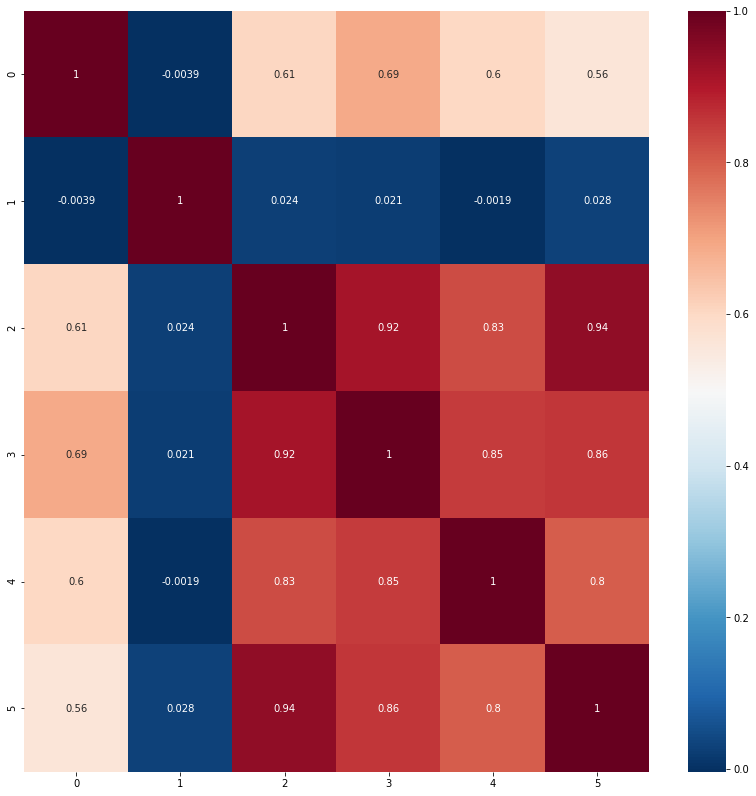

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.figure(figsize=(14, 14))
sns.heatmap(pd.DataFrame(metaX).corr(),
            annot=True,
            cmap="RdBu_r")